In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns; sns.set()
!pip install kneed

# **Desafio I2A2 - Clusterização e redução de dimensionalidade de sequenciamento genético**
*   Aluna: Carolina Bezerra
*   Entrega: 03/04/22

## 1. Introdução

O DNA é responsavel pela transmissão de caracteristicas de pai para filho. No processo de transcrição e tradução do DNA, as informações nela contidas irão ser passadas para o RNA e reproduzidas em características. O RNA irá realizar uma leitura da fita de DNA e isso irá transcrever todas as informações que estão no DNA. A partir dessa transcrição, as proteínas responsáveis por determinar a função celular irão ser codificadas. Em resumo, a informação contida no DNA irá determinar os resultados do percurso transcrição-tradução, de modo a configurar como as proteínas do corpo irão se comportar. 

Esse processo transcrição-tradução, conhecido como trasncriptoma, fornece o conjunto completo de transcritos (RNAs mensageiros, RNAs ribossômicos, RNAs transportadores e os microRNAs) de um dado organismo, órgão, tecido ou linhagem celular. A evolução da bioinformática, iniciada com análises de sequenciamento, tem oferecido avanços nessa ciência principalmente nas anotações dos transcriptomas, permitindo a interrelação entre o genoma funcional e a informação codificada.

A análise do transcriptoma com RNA-Seq pode ser realizada com ou sem uma sequência genômica de referência. No presente trabalho, tem-se o primeiro caso (conhecido como *reference-guided*) e esta abordagem geralmente é empregada quando estamos analisando genomas microbianos ou eucarióticos “modelo” (ex: Homo sapiens, Mus musculus). No caso da análise *reference-guided*, os resultados do sequenciamento, as leituras (*reads*), são alinhadas contra o genoma e a contagem de leituras (*read counts*) mapeadas em cada gene é usada para medir a sua expressão.

A contagem de leituras (*read counts*) fornecem um resumo geral da cobertura do 
recurso genômico de interesse. Em particular, as contagens em nível de gene de RNA-Seq fornecem um resumo geral do nível de expressão do gene. Uma vez que tenhamos nossas leituras alinhadas ao genoma, o próximo passo é contar quantas leituras foram mapeadas para cada gene.

Fontes: 
* https://medium.com/omixdata/an%C3%A1lise-de-express%C3%A3o-g%C3%AAnica-diferencial-com-rna-seq-reference-guided-43804a500f92
* https://slptophp.net/o-que-e-o-transcriptoma/
* https://edisciplinas.usp.br/pluginfile.php/5727316/mod_resource/content/0/Palestra-%20Como%20processar%20dados%20de%20RNA-Seq.pdf



## 2. Objetivo

Este é um trabalho de aprendizado não-supervisionado cujo objetivo é encontrar semelhança entre pessoas e classifica-las como parentes ou não, com base em suas similaridades genéticas. A base de dados utilizada contém ‘readcounts’ obtidos a partir da atividade genética decorrente da transcrição DNA-RNA de um conjunto de células de diferentes indivíduos. O arquivo possui um total de 65000 genes mapeados em 48 pessoas diferentes.

## 3. Compreensão dos dados
O conjunto de dados utilizado é um registro de 65000 informações genéticas codificadas que foram previamente mapeadas para 48 pessoas. Essas informações estão codificadas na terminologia ENSGXXXXXXXXX, onde X é apenas um número identificador. Em cada célula da planilha do conjunto de dados tem-se a quantidade de leituras de uma expressão genética ENSGXXXXXXXXX para cada indivíduo, conforme é mostrado abaixo. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/IPTI_challenges/c4-Mapeamento-Genetico/Ca/readcounts.xlsx", header=0, index_col=0)

In [ ]:
df.head()

,H223,H224,H225,H226,H227,H228,H229,H230,H231,H232,...,H261,H262,H263,H264,H265,H266,H267,H268,H269,H270
ENSG00000000003,0,0,0,1,0,0,0,0,1,0,...,0,1,0,1,0,2,0,0,1,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ENSG00000000419,1216,1228,1022,912,491,449,466,727,774,576,...,980,932,360,450,484,926,803,630,537,582
ENSG00000000457,189,114,110,289,186,148,169,258,145,131,...,117,286,137,90,105,275,101,56,87,81
ENSG00000000460,74,38,55,127,30,17,45,100,33,8,...,28,157,34,20,15,139,54,25,21,47


Para mais informações sobre o que representa cada código genético, o usuário pode consultar o banco de dados fornecido pelo website [Ensembl](https://www.ensembl.org/index.html?redirect=no), um navegador de genoma para genomas de vertebrados que suporta pesquisas em genômica comparativa, evolução, variação de sequência e regulação transcricional. 

## 4. Preparação e limpeza dos dados

Primeiro, o dataset é transposto para que as informações (features) dos dados fiquem armazenadas em colunas.

In [ ]:
df_T = df.T
print("Dimensão do dataset", df_T.shape)

Dimensão do dataset (48, 65215)


Utilizando o método .describe() do pandas, pode-se visualizar alguns dados estatísticos do dataset e ter uma visão geral de como os dados estão descritos. 

In [ ]:
df_T.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281913,ENSG00000281914,ENSG00000281915,ENSG00000281916,ENSG00000281917,ENSG00000281918,ENSG00000281919,ENSG00000281920,ENSG00000281921,ENSG00000281922
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.0,48.0,48.0,48.0,48.0,48.000000,48.0,48.000000,48.0,48.0
mean,0.250000,0.041667,709.125000,136.395833,44.916667,16644.916667,4.812500,485.333333,4616.083333,932.729167,...,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.020833,0.0,0.0
std,0.525924,0.201941,224.728453,62.975760,35.518550,10818.838971,4.979346,392.373049,8357.175334,340.895862,...,0.0,0.0,0.0,0.0,0.0,0.201941,0.0,0.144338,0.0,0.0
min,0.000000,0.000000,318.000000,56.000000,7.000000,3319.000000,0.000000,73.000000,51.000000,438.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,0.000000,0.000000,540.750000,90.000000,21.000000,8773.750000,1.000000,135.750000,525.250000,672.750000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
50%,0.000000,0.000000,686.000000,114.500000,31.500000,11843.000000,3.000000,343.500000,1062.500000,828.500000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
75%,0.000000,0.000000,884.000000,157.000000,54.000000,27380.500000,8.000000,745.000000,4060.500000,1187.500000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
max,2.000000,1.000000,1228.000000,289.000000,157.000000,41846.000000,19.000000,1585.000000,40184.000000,1734.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0


Nota-se em algums colunas que o dataset possui uma variância muito baixa nos dados, o que significa que podemos ter uma quantidade grande de colunas com a maior parte das células contendo zeros.

Vamos verificar se existem valores ausentes em nosso dataset.

In [ ]:
missing_values = df_T.isnull().mean()*100
print(missing_values)

ENSG00000000003    0.0
ENSG00000000005    0.0
ENSG00000000419    0.0
ENSG00000000457    0.0
ENSG00000000460    0.0
                  ... 
ENSG00000281918    0.0
ENSG00000281919    0.0
ENSG00000281920    0.0
ENSG00000281921    0.0
ENSG00000281922    0.0
Length: 65215, dtype: float64


Verificando quantidade de zero nas colunas.

In [ ]:
zero_values = df_T.isin([0]).mean()*100
print(zero_values)

ENSG00000000003     79.166667
ENSG00000000005     95.833333
ENSG00000000419      0.000000
ENSG00000000457      0.000000
ENSG00000000460      0.000000
                      ...    
ENSG00000281918     95.833333
ENSG00000281919    100.000000
ENSG00000281920     97.916667
ENSG00000281921    100.000000
ENSG00000281922    100.000000
Length: 65215, dtype: float64


Existem algumas colunas com todos os dados iguais a zero e outras com mais de 70% dos dados iguais a zero. Pergunta, devemos excluir essas colunas?

Eliminando as colunas com 100% dos dados iguais a zero

In [ ]:
df_T1 = df_T.loc[:, (df_T != 0).any(axis=0)]
zero_values_1 = df_T1.isin([0]).mean()*100
print(zero_values_1)

ENSG00000000003    79.166667
ENSG00000000005    95.833333
ENSG00000000419     0.000000
ENSG00000000457     0.000000
ENSG00000000460     0.000000
                     ...    
ENSG00000281904    97.916667
ENSG00000281909    93.750000
ENSG00000281912    45.833333
ENSG00000281918    95.833333
ENSG00000281920    97.916667
Length: 44678, dtype: float64


In [ ]:
print("A dimensão do dataset agora é", df_T1.shape)

A dimensão do dataset agora é (48, 44678)


Após a eliminação, ficaram um total de 44678 colunas. Foram eliminadas 20537 colunas.

Como o dataset possui escalas muito diferentes (varia desde 1 até 6 digítos, por exemplo), deve-se padronizar os dados. O método utilizado para padronização será o StandardScaler(). 

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_T1_scaled = scaler.fit_transform(df_T1)
df_T1_scaled

array([[-0.48038446, -0.20851441,  2.27936827, ..., -0.01763638,
        -0.20851441, -0.14586499],
       [-0.48038446, -0.20851441,  2.33333112, ..., -0.01763638,
        -0.20851441, -0.14586499],
       [-0.48038446, -0.20851441,  1.40696887, ..., -0.86418275,
        -0.20851441, -0.14586499],
       ...,
       [-0.48038446, -0.20851441, -0.35581754, ..., -0.86418275,
        -0.20851441, -0.14586499],
       [ 1.44115338, -0.20851441, -0.77402962, ..., -0.86418275,
        -0.20851441, -0.14586499],
       [-0.48038446, -0.20851441, -0.57166894, ..., -0.86418275,
        -0.20851441, -0.14586499]])

## 5. Modelagem dos dados

**Aplicando o método de redução de dimensionalidade - Método PCA**

A Análise de Componentes Principais (PCA) é uma técnica popular de aprendizado de máquina não supervisionada que é usada para reduzir o número de variáveis de entrada no conjunto de dados de treinamento. Esta técnica vem sob a técnica de redução de dimensionalidade. Na analise dos componentes principais, a relação entre os dados é explicada por encontrar a lista principal de eixos nos dados e utilizar esses eixos para descrever o dataset. Utilizando o estimador PCA a partir da biblioteca Scikit-learn, computa-se os dados como segue:

In [ ]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA(n_components=10)
pca = PCA()
pca_scores = pca.fit_transform(df_T1_scaled) # Aplica a redução de dimensionalidade ao modelo

NameError: ignored

In [ ]:
pca_scores

O ajuste aprende algumas quantidades dos dados, principalmente os "componentes" e a "variância explicada". # O objeto pca.components_ contém os pesos (também chamados de 'carregamentos') de cada Componente Principal. É usando esses pesos que os componentes principais finais são formados.

In [ ]:
print(pca.components_)

In [ ]:
df_pca_loadings = pd.DataFrame(pca.components_)
df_pca_loadings.head()

In [ ]:
pca_model = pd.DataFrame(pca_scores)
pca_model.head()

Taxa de variancia dos dados do modelo, do mais significativo para o menos significativo.

In [ ]:
print(pca.explained_variance_ratio_*100)

In [ ]:
ggplot_styles = {
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white', #EBEBEB
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'grid.color': 'EBEBEB',
    'grid.linewidth': '1.0',
    'xtick.color': 'black', #555555
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': 'black', #555555
    'ytick.major.left': True,
    'ytick.minor.left': False,
}

plt.rcParams.update(ggplot_styles)

Plotando a variância explicada para todos os componentes (features) em relação aos dados.

In [ ]:
# Plot the explained variances
plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_*100, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(pca_scores)

Uma parte vital do uso do PCA na prática é a capacidade de estimar quantos componentes são necessários para descrever os dados. Isso pode ser determinado observando a razão de variância explicada cumulativa em função do número de componentes:

In [ ]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True

plt.plot(range(pca.n_components_), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Variância explicada pelos componentes')
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')

## 6. Clusterização K-Means a partir dos resultados do PCA

Nesse momento, iremos combinar PCA e K-means para segmentar nossos dados, onde utilizamos os escores obtidos pelo PCA para o ajuste. Sabemos que o K-means não determina o número de clusters em sua solução.

Logo, precisamos determinar o número de clusters em um algoritmo K-means.
Para isso, executamos o algoritmo com um número diferente de clusters. Em seguida, determinamos o Within Cluster Sum of Squares ou WCSS para cada solução. Com base nos valores do WCSS e em uma abordagem conhecida como método Elbow, tomamos uma decisão sobre quantos clusters gostaríamos de manter.

Fontes: 
* https://365datascience.com/tutorials/python-tutorials/pca-k-means/
* https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
* https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
* https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [ ]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,10):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans_pca.fit(pca_scores)
  wcss.append(kmeans_pca.inertia_)

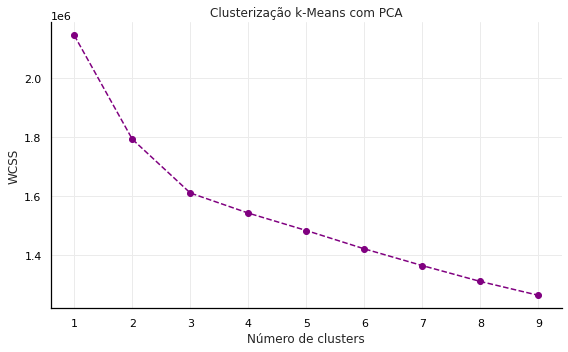

In [ ]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True

plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--', color = 'purple')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Clusterização k-Means com PCA')
plt.show()

In [ ]:
from kneed import KneeLocator

locator_cluster = KneeLocator( range(1, 10), wcss, curve="convex", direction="decreasing")

print('O numero de clusters com os dados padronizados é:', locator_cluster.elbow)

O numero de clusters com os dados padronizados é: 3


In [ ]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=3, random_state=42)

Vamos visualizar os clusters em um plano 2D, logo, precisamos escolher dois componentes e usá-los como eixos. O objetivo do PCA era determinar os componentes mais importantes. Dessa forma, podemos ter certeza absoluta de que os dois primeiros componentes explicam mais variância do que o terceiro.

In [ ]:
df_pca_2comp = PCA(n_components=2)
df_pca_2comp_fit = df_pca_2comp.fit_transform(df_T1_scaled)

In [ ]:
df_pca_kmeans = pd.concat([df_T1.reset_index(drop = True), pd.DataFrame(df_pca_2comp_fit)], axis = 1)

df_pca_kmeans.columns.values[-2:] = ['pca1', 'pca2']
df_pca_kmeans['segment kmeans pca'] = kmeans_pca.labels_

In [ ]:
df_pca_kmeans['segment'] = df_pca_kmeans['segment kmeans pca'].map({0: '1', 1: '2', 2:'3'})

In [ ]:
df_pca_kmeans.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281918,ENSG00000281920,pca1,pca2,segment kmeans pca,segment
0,0,0,1216,189,74,31895,2,763,8963,1589,...,18,0,0,1,0,0,68.193082,86.751609,0,1
1,0,0,1228,114,38,23361,3,712,26794,1734,...,0,0,0,1,0,0,43.357053,106.819621,0,1
2,0,0,1022,110,55,27944,0,956,8027,1341,...,10,0,0,0,0,0,27.176902,82.837012,0,1
3,1,0,912,289,127,41846,6,1104,716,1053,...,36,0,0,2,0,0,141.706001,-64.261071,1,2
4,0,0,491,186,30,11929,14,136,745,730,...,17,0,0,0,0,0,-92.460610,-38.537078,2,3


In [ ]:
df_pca_2comp = PCA(n_components=2)
df_pca_2comp_fit = df_pca_2comp.fit_transform(df_T1_scaled)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


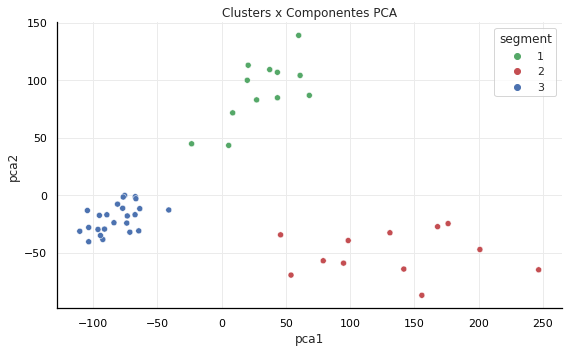

In [ ]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True

x_axis = df_pca_kmeans['pca1']
y_axis = df_pca_kmeans['pca2']

sns.scatterplot(x_axis, y_axis, hue = df_pca_kmeans['segment'], palette = ['g', 'r', 'b'])
plt.title('Clusters x Componentes PCA')
plt.show()

**Visualizando as famílias utilizando o dendograma**

No entanto, no mundo real, podemos ter milhares de pontos de dados em muito mais de 2 dimensões. Nesse caso, não seria possível detectar aglomerados a olho nu. Em nosso dataset, temos um conjunto de dados (pessoas) pertencentes a um mesmo grupo familiar. Para visualizarmos esse agrupamento, iremos recorrer a biblioteca scipy.  

In [ ]:
df_T1.index

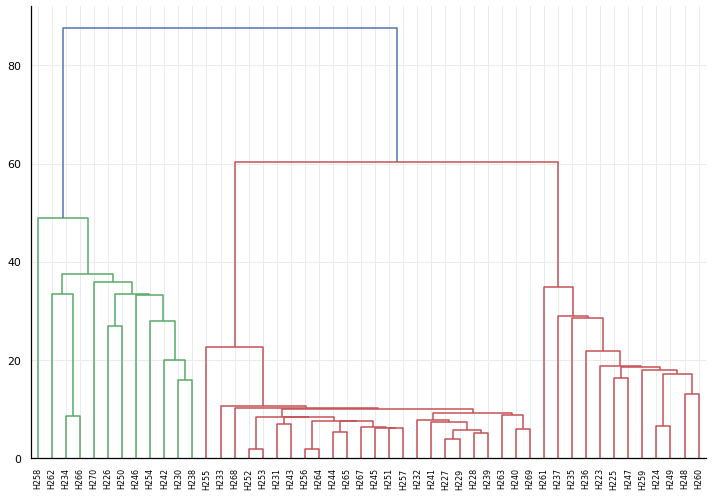

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(df_pca_2comp_fit, 'single')

# labelList = range(pca.n_components_)
labelList = df_T1.index 

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_pca_2comp_fit)

array([2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0,
       1, 1, 1, 0])

In [ ]:
df_T1.index

Index(['H223', 'H224', 'H225', 'H226', 'H227', 'H228', 'H229', 'H230', 'H231',
       'H232', 'H233', 'H234', 'H235', 'H236', 'H237', 'H238', 'H239', 'H240',
       'H241', 'H242', 'H243', 'H244', 'H245', 'H246', 'H247', 'H248', 'H249',
       'H250', 'H251', 'H252', 'H253', 'H254', 'H255', 'H256', 'H257', 'H258',
       'H259', 'H260', 'H261', 'H262', 'H263', 'H264', 'H265', 'H266', 'H267',
       'H268', 'H269', 'H270'],
      dtype='object')

In [ ]:
list2 = [2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0,
       1, 1, 1, 0]
list1 = ['H223', 'H224', 'H225', 'H226', 'H227', 'H228', 'H229', 'H230', 'H231', 'H232', 'H233', 'H234', 'H235', 'H236', 'H237', 'H238', 'H239', 'H240', 'H241', 'H242', 'H243', 'H244', 'H245', 'H246', 'H247', 'H248', 'H249', 'H250', 'H251', 'H252', 'H253', 'H254', 'H255', 'H256', 'H257', 'H258', 'H259', 'H260', 'H261', 'H262', 'H263', 'H264', 'H265', 'H266', 'H267', 'H268', 'H269', 'H270']

In [ ]:
zipped = list(zip(list2, list1))
df_familias= pd.DataFrame(zipped, columns=['Familia','Pessoas'])

In [ ]:
df_familias.head()

,Familia,Pessoas
0,2,H223
1,2,H224
2,2,H225
3,0,H226
4,1,H227


De acordo com o resultado do dendograma, e do número de clusters considerados para agrupamento dos parentes, temos no sentido da esquerda para direita no eixo horizontal:
* 1ª família: 12 parentes 
* 2ª família: 24 parentes
* 3ª família: 12 parentes

Parentes da 1ª família:

In [ ]:
df1 = df_familias.loc[df_familias['Familia']==0].T
df1

,3,7,11,15,19,23,27,31,35,39,43,47
Familia,0,0,0,0,0,0,0,0,0,0,0,0
Pessoas,H226,H230,H234,H238,H242,H246,H250,H254,H258,H262,H266,H270


Parentes da 2ª família:

In [ ]:
df2 = df_familias.loc[df_familias['Familia']==1].T
df2

,4,5,6,8,9,10,16,17,18,20,...,30,32,33,34,40,41,42,44,45,46
Familia,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Pessoas,H227,H228,H229,H231,H232,H233,H239,H240,H241,H243,...,H253,H255,H256,H257,H263,H264,H265,H267,H268,H269


Parentes da 3ª família:

In [ ]:
df3 = df_familias.loc[df_familias['Familia']==2].T
df3

,0,1,2,12,13,14,24,25,26,36,37,38
Familia,2,2,2,2,2,2,2,2,2,2,2,2
Pessoas,H223,H224,H225,H235,H236,H237,H247,H248,H249,H259,H260,H261
